In [1]:
from pathlib import Path
import sys
import yaml
import time
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

%matplotlib inline

manger init
mangager register
mangager register


In [2]:
def get_yelp_api_key():
    with open("../config.yml", 'r') as yml:
        cfg = yaml.safe_load(yml)
        return cfg["yelp"]["api_key"]

def plot_background():
    background_path = os.path.join('..', 'data', 'plot', 'background')
    city = gpd.read_file(os.path.join(background_path, "madison-meter-shp"))
    lakes = gpd.read_file(os.path.join(background_path, "water-meter-shp"))
    street = gpd.read_file(os.path.join(background_path, "street-meter-shp"))
    # city = gpd.read_file(background_path + "madison-shp")
    # lakes = gpd.read_file(background_path + "water-shp")
    # street = gpd.read_file(background_path + "street-shp")

    ax = city.plot(color="lightgray", alpha=.2, figsize=(12, 12), zorder=2)
    lakes.plot(color="lightblue", ax=ax, zorder=1, alpha=0.8)
    street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    return ax

# route remove study

In [3]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

stops_meter exists


In [4]:
# routes = [ 2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
#        23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55,
#        67, 70, 72, 73, 75, 59, 63, 68, 78, 80, 84, 81, 82]

routes = [80]
for route in routes:
    print(route)
    gtfo.set_batch_label(f"{route}-rm")
    config = Config(day="monday", elapse_time="00:20:00", interval="03:00:00", max_walking_min=10, route_remove=[route])
    config.set_starts(centroids=census_gdf)

    perf_df = pd.DataFrame(
            columns=["geometry", "start_time", "search_time", "add_service_time", "add_census_time"])
    result_gdf = gtfo.search(config, perf_df)
    gtfo.add_service_metrics(result_gdf, services_gdf, perf_df)
#     gtfo.add_demographic_metrics(result_gdf, census_gdf, perf_df)
    result_gdf.to_csv(os.path.join('.', 'out', f'result{route}.csv'), index=False)
    perf_df.to_csv(os.path.join('.', 'out', f'perf{route}.csv'), index=False)

80
get available manager
manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7fabdee25f70>
key='local'
manager=<class 'SCanalyzer.busSim.manager.localManager.LocalManager'>
Empty DataFrame
Columns: [geometry, start_time, search_time, add_service_time, add_census_time]
Index: []


100%|██████████| 2224/2224 [00:29<00:00, 75.23it/s] 


IndexError: index 0 is out of bounds for axis 0 with size 0

In [8]:
result_gdf

,geometry,start_time,map_identifier
0,POINT (-89.65749071743502 43.12558522013633),0:0:00,search-result-0-0!0
1,POINT (-89.58410468038977 42.9977144585),0:0:00,search-result-0-0!1
2,POINT (-89.52480673380735 43.0440282770501),0:0:00,search-result-0-0!2
3,POINT (-89.52461125108374 43.02680593102333),0:0:00,search-result-0-0!3
4,POINT (-89.51016191651111 43.0479695906991),0:0:00,search-result-0-0!4
...,...,...,...
2219,POINT (-89.2543335991909 43.17941696996946),21:0:00,search-result-0-1260!273
2220,POINT (-89.22025804318837 43.18544080303251),21:0:00,search-result-0-1260!274
2221,POINT (-89.23124966766352 43.05574718320674),21:0:00,search-result-0-1260!275
2222,POINT (-89.19161761144784 43.21318565393248),21:0:00,search-result-0-1260!276


In [6]:
perf_df

,geometry,start_time,search_time,add_service_time,add_census_time
0,POINT (-89.65749071743502 43.12558522013633),0:0:00,0.024972,0.007778,0.013161
1,POINT (-89.58410468038977 42.9977144585),0:0:00,0.011121,0.006551,0.00143
2,POINT (-89.52480673380735 43.0440282770501),0:0:00,0.008593,0.004369,0.000797
3,POINT (-89.52461125108374 43.02680593102333),0:0:00,0.009065,0.004865,0.000922
4,POINT (-89.51016191651111 43.0479695906991),0:0:00,0.008762,0.004694,0.000976
...,...,...,...,...,...
3331,POINT (-89.2543335991909 43.17941696996946),22:0:00,0.013845,0.004522,0.00034
3332,POINT (-89.22025804318837 43.18544080303251),22:0:00,0.015895,0.004307,0.000329
3333,POINT (-89.23124966766352 43.05574718320674),22:0:00,0.01429,0.005757,0.00034
3334,POINT (-89.19161761144784 43.21318565393248),22:0:00,0.013779,0.004328,0.000388


# route doubling study

In [7]:
print(perf_df)

                                          geometry start_time search_time  \
0     POINT (-89.65749071743502 43.12558522013633)     0:0:00    0.024972   
1         POINT (-89.58410468038977 42.9977144585)     0:0:00    0.011121   
2      POINT (-89.52480673380735 43.0440282770501)     0:0:00    0.008593   
3     POINT (-89.52461125108374 43.02680593102333)     0:0:00    0.009065   
4      POINT (-89.51016191651111 43.0479695906991)     0:0:00    0.008762   
...                                            ...        ...         ...   
3331   POINT (-89.2543335991909 43.17941696996946)    22:0:00    0.013845   
3332  POINT (-89.22025804318837 43.18544080303251)    22:0:00    0.015895   
3333  POINT (-89.23124966766352 43.05574718320674)    22:0:00     0.01429   
3334  POINT (-89.19161761144784 43.21318565393248)    22:0:00    0.013779   
3335  POINT (-89.19791660630933 42.98254107176306)    22:0:00    0.015122   

      add_service_time add_census_time  
0             0.007778        0.01

In [8]:
sc = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = sc.load_census()
services_gdf = sc.load_yelp(api_key=api_key)
config = Config(day="monday", elapse_time="00:30:00", interval="10:10:00", max_walking_min=10)
config.set_starts(centroids=census_gdf)

routes = [ 2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
       23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55,
       67, 70, 72, 73, 75, 59, 63, 68, 78, 80, 84, 81, 82]
routes = [80]

result_folder = os.path.join('.', 'out', 'result')
perf_folder = os.path.join('.', 'out', 'perf')
if not os.path.exists(result_folder): os.makedirs(result_folder)
if not os.path.exists(perf_folder): os.makedirs(perf_folder)

for route in routes:
    print(route)
    sc.gtfs_edit(edit_double, route)
    sc.set_batch_label(f"{route}-double")
    perf_df = pd.DataFrame(
            columns=["geometry", "start_time", "search_time", "add_service_time", "add_census_time"])
    result_gdf = sc.search(config, perf_df)
    sc.add_service_metrics(result_gdf, services_gdf, perf_df)
    sc.add_demographic_metrics(result_gdf, census_gdf, perf_df)
    result_gdf.to_csv(os.path.join('.', 'out', 'result', f'result{route}-double.csv'), index=False)
    perf_df.to_csv(os.path.join('.', 'out', 'perf', f'perf{route}-double.csv'), index=False)
    break

80
get available manager
manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7f66b3f185b0>
key='local'
manager=<class 'SCanalyzer.busSim.manager.localManager.LocalManager'>
Empty DataFrame
Columns: [geometry, start_time, search_time, add_service_time, add_census_time]
Index: []


100%|█████████████████████████████████████████| 834/834 [00:15<00:00, 52.66it/s]


In [9]:
sc = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = sc.load_census()
config = Config(day="monday", elapse_time="00:30:00", interval="10:00:00", max_walking_min=10)
# config.set_starts(points=[(43.073691, -89.387407), (43.073691, -89.387407)])
config.set_starts(centroids=census_gdf)
t0 = time.time()
result_gdf = sc.search(config)
t1 = time.time()
print(t1-t0)

services_gdf = sc.load_yelp(api_key=api_key)
sc.add_service_metrics(result_gdf, services_gdf)
t2 = time.time()
print(t2-t1)

sc.add_demographic_metrics(result_gdf, census_gdf) # SLOW
t3 = time.time()
print(t3-t2)
result_gdf["banks"].sum() #7263.0

get available manager
manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7f66b3f185b0>
key='local'
manager=<class 'SCanalyzer.busSim.manager.localManager.LocalManager'>
None


100%|█████████████████████████████████████████| 834/834 [00:14<00:00, 56.19it/s]


14.855933666229248
5.972348690032959
2.8650624752044678


4717.0

In [10]:
sc.gtfs_edit(edit_double, 80)
t0 = time.time()
result_gdf = sc.search(config)
t1 = time.time()
print(t1-t0)

services_gdf = sc.load_yelp(api_key=api_key)
sc.add_service_metrics(result_gdf, services_gdf)
t2 = time.time()
print(t2-t1)

sc.add_demographic_metrics(result_gdf, census_gdf) # SLOW
t3 = time.time()
print(t3-t2)
result_gdf["banks"].sum() #7263.0

get available manager
manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7f66b3f185b0>
key='local'
manager=<class 'SCanalyzer.busSim.manager.localManager.LocalManager'>
None


100%|█████████████████████████████████████████| 834/834 [00:16<00:00, 49.55it/s]


16.841368913650513
5.779432773590088
2.8424856662750244


4727.0

In [11]:
result = pd.read_csv(os.path.join('.', 'out', 'result', 'result80-double.csv'))
result["banks"].sum()

4322.0

# Visualize simulation

/home/young/.local/lib/python3.8/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

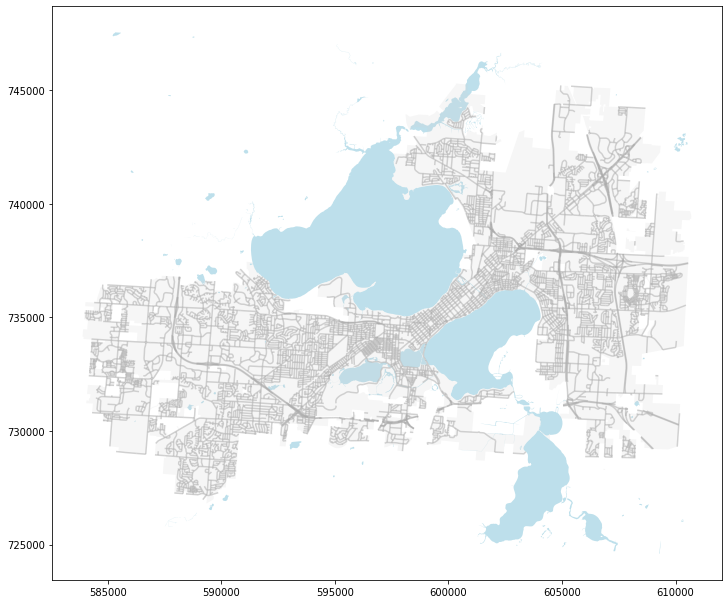

In [12]:
gtfo = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
ax = plot_background()
gtfo.set_batch_label(f"80-rm")
example_gdf = gtfo.load_result_map(map_identifier="search-result-0-600!10")
example_gdf.plot(color="#ffbfba", ax=ax)

# AWS test

In [13]:
from SCanalyzer.busSim.manager import managerFactory
aws = managerFactory.create("aws", gtfs_path=None, city_path=None, out_path=None)

manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7f66b3f185b0>
key='aws'
manager=<class 'SCanalyzer.busSim.manager.AWSManager.AWSManager'>


TypeError: __init__() got an unexpected keyword argument 'city_path'

In [ ]:
aws.clean_up()

In [ ]:
import boto3
aws_lambda = boto3.client('lambda', region_name='ap-northeast-1')
with open("tmp.zip", 'rb') as f:
    response = aws_lambda.create_function(
        Code={
            'ZipFile': f.read()
        },
        Description='BusSim handler',
        FunctionName="test",
        Handler='lambda_function.lambda_handler',
        MemorySize=512,
        Publish=True,
        Role="arn:aws:iam::347664766527:role/s3rwRole",
        Runtime='python3.8',
        Timeout=900,
        TracingConfig={
            'Mode': 'Active',
        },
    )